In [1]:
#downloading data
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 37.47 MiB/s, done.
Updating files: 100% (12160/12160), done.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [3]:
datadir= 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data= pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names= columns)
data.head()

center  \
0  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
1  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
2  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
3  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
4  C:\Users\Amer\Desktop\new_track\IMG\center_201...   

                                                left  \
0  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
1  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
2  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
3  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
4  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   

                                               right  steering  throttle  \
0  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
1  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
2  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
3  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
4  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   

   reverse     speed  
0      0.0  0.649786  
1      0.0  0.627942  
2      0.0  0.622910  
3      0.0  0.619162  
4      0.0  0.615438

In [4]:
def path_leaf(path):
    head, tail= ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg       0.0       0.0      0.0  0.649786  
1  right_2018_07_16_17_11_43_670.jpg       0.0       0.0      0.0  0.627942  
2  right_2018_07_16_17_11_43_724.jpg       0.0       0.0      0.0  0.622910  
3  right_2018_07_16_17_11_43_792.jpg       0.0       0.0      0.0  0.619162  
4  right_2018_07_16_17_11_43_860.jpg       0.0       0.0      0.0  0.615438

In [16]:
#Data Visualisation

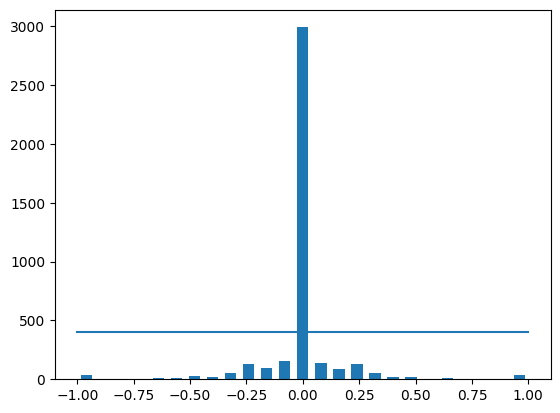

In [7]:
num_bins = 25
samples_per_bin= 400
hist, bins= np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [8]:
print('total data:', len(data))
print (data.shape)

total data: 4053
(4053, 7)


In [9]:
remove_list= []
for j in range (num_bins):
    list_=[]
    for i in  range (len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_= shuffle(list_)
    list_= list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace= True)
print('remaining: ', len(data))

removed:  2590
remaining:  1463


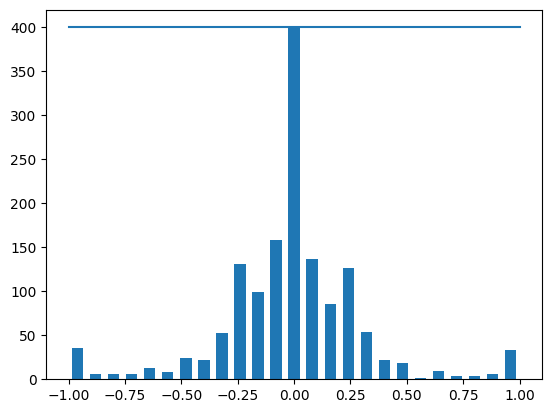

In [10]:
hist, _= np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [11]:
def load_img_steering(datadir, df):
    image_path= []
    steering = []
    for i in range (len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        #center image append
        image_path.append(os.path. join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        #right image append
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3])+0.15)
        #left image append
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

In [12]:
image_paths, steerings= load_img_steering(datadir + '/IMG', data)

In [14]:
image_paths, len(image_paths)

(array(['track/IMG/center_2018_07_16_17_11_43_670.jpg',
        'track/IMG/right_2018_07_16_17_11_43_670.jpg',
        'track/IMG/left_2018_07_16_17_11_43_670.jpg', ...,
        'track/IMG/center_2018_07_16_17_16_31_474.jpg',
        'track/IMG/right_2018_07_16_17_16_31_474.jpg',
        'track/IMG/left_2018_07_16_17_16_31_474.jpg'], dtype='<U44'),
 4389)

In [15]:
steerings, len(steerings)

(array([ 0.  ,  0.15, -0.15, ...,  0.  ,  0.15, -0.15]), 4389)

In [17]:
# Spliting training set and validation set

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples:{}\nValid Samples:{}'.format(len(X_train), len(X_valid)))

Training Samples:3511
Valid Samples:878


Text(0.5, 1.0, 'Validation Set')

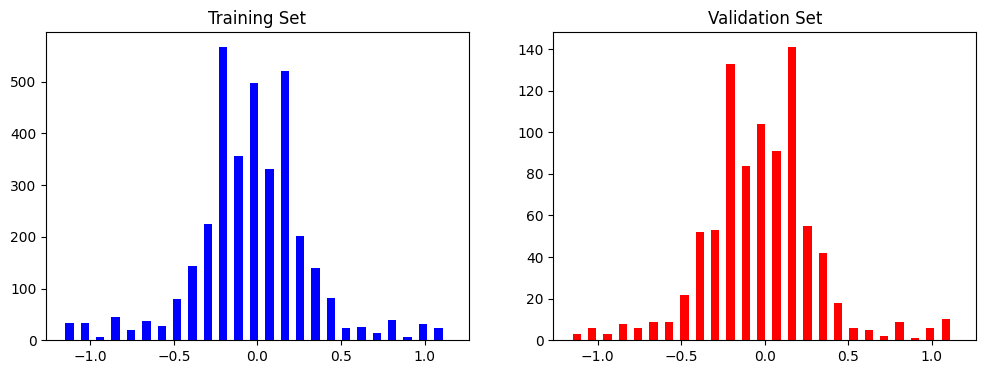

In [19]:
fig, axes = plt.subplots(1,2,figsize= (12,4))
axes[0].hist(y_train, bins= num_bins, width= 0.05, color=  'blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid, bins= num_bins, width= 0.05, color= 'red')
axes[1].set_title('Validation Set')

In [20]:
# Data Augmentation

In [21]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

Text(0.5, 1.0, 'Zoomed Image')

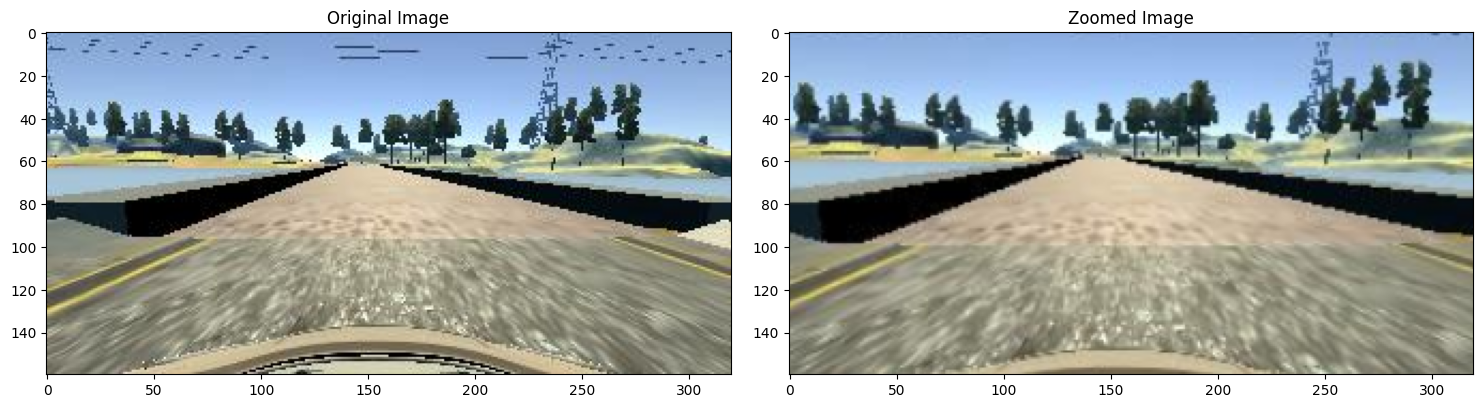

In [23]:
fig, axs= plt.subplots(1,2,figsize= (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

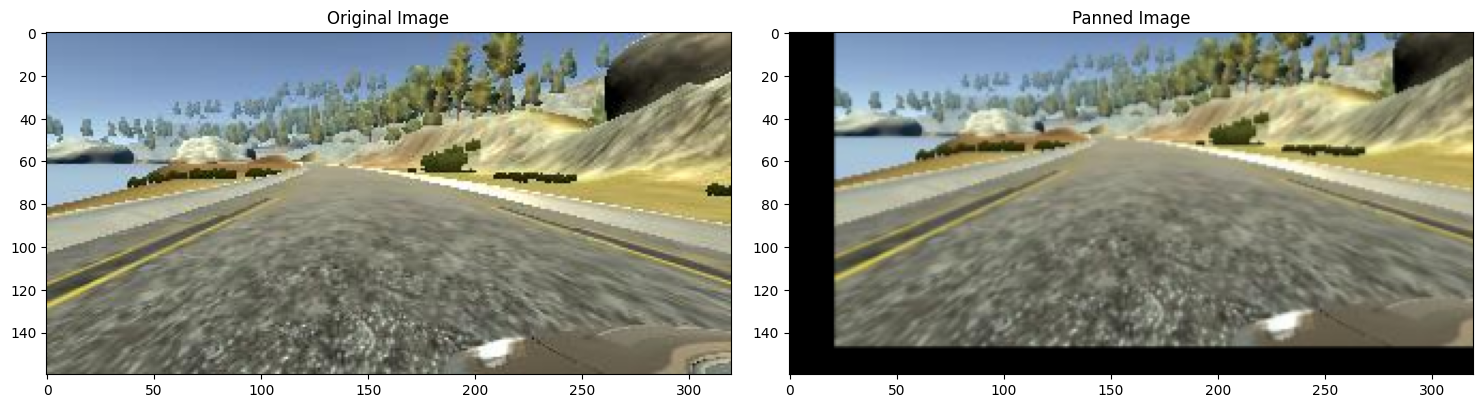

In [24]:
def pan(image):
    pan= iaa.Affine(translate_percent={"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image =pan.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image= mpimg.imread(image)
panned_image = pan(original_image)

fig, axs= plt.subplots(1,2,figsize= (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness Altered Image')

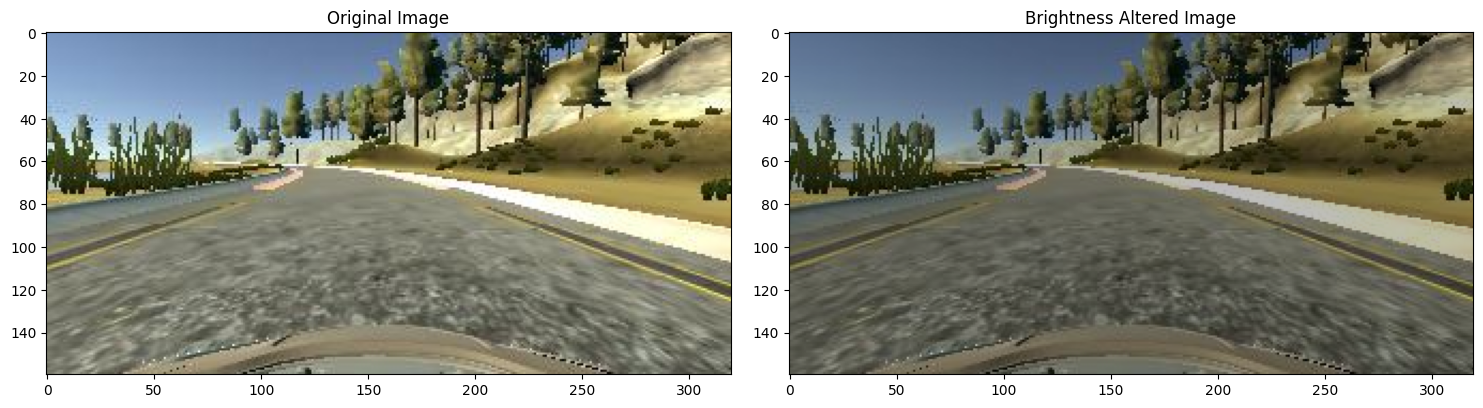

In [25]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image= image_paths[random.randint(0, 1000)]
original_image= mpimg.imread(image)
brightness_altered_image = img_random_brightness (original_image)

fig, axs= plt.subplots(1,2,figsize= (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

Text(0.5, 1.0, 'Flipped Image- Steering Angle: 0.15')

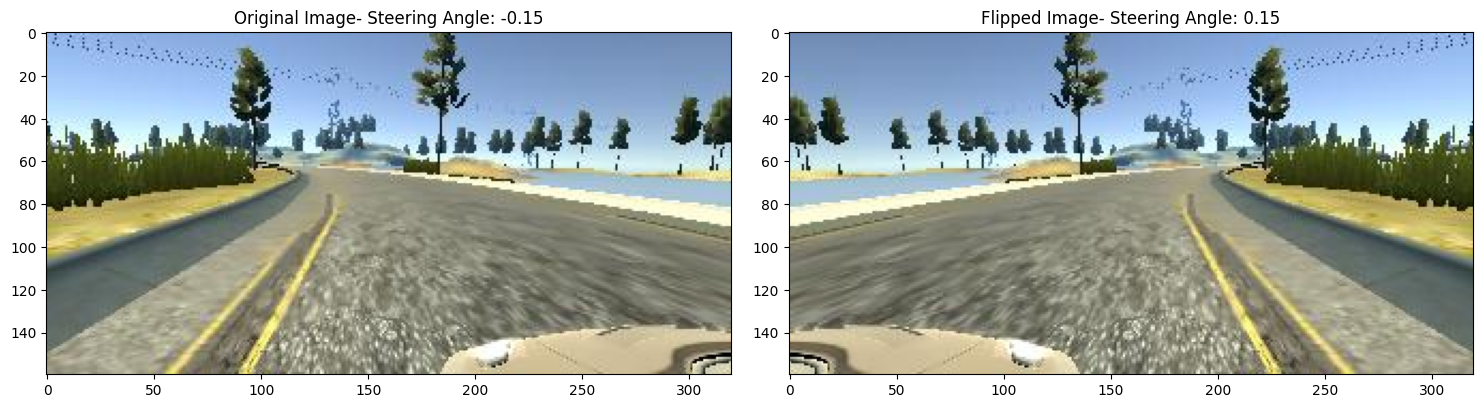

In [26]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image= mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs= plt.subplots(1,2,figsize= (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image- ' + 'Steering Angle: '+ str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image- '+ 'Steering Angle: ' + str(flipped_steering_angle))

In [27]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand()<0.5:
        image= zoom(image)
    if np.random.rand()< 0.5:
        image= img_random_brightness(image)
    if np.random.rand()<0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

Text(0.5, 1.0, 'Augmented Image')

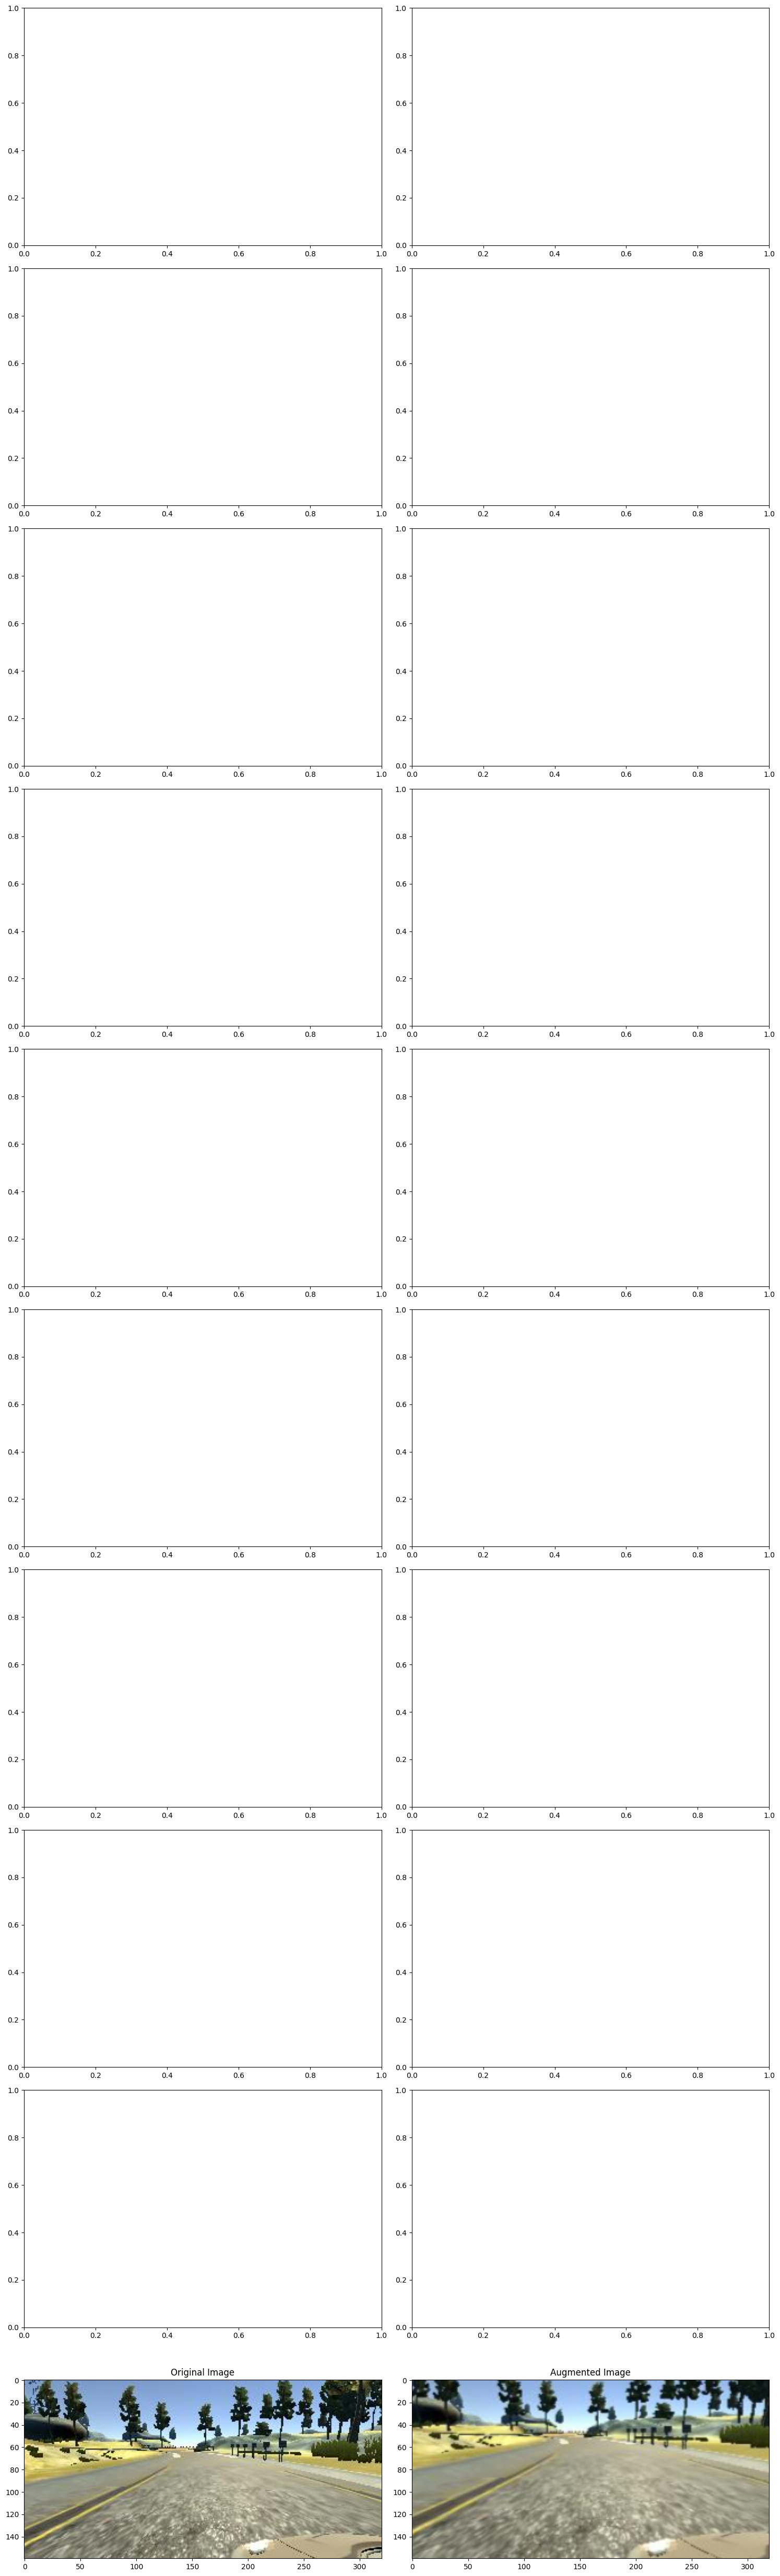

In [28]:
ncol= 2
nrow= 10

fig, axs = plt.subplots(nrow, ncol, figsize = (15, 50))
fig.tight_layout()

for i in range(10):
    randnum= random.randint(0, len(image_paths)-1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    #original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

axs[i][0].imshow(mpimg.imread(random_image))
axs[i][0].set_title("Original Image")

axs[i][1].imshow(augmented_image)
axs[i][1].set_title("Augmented Image")

In [29]:
#Image Preprocessing

In [30]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3),0)
    img = cv2.resize(img, (200, 66))
    img= img/255
    return img

Text(0.5, 1.0, 'Preprocessed Iamge')

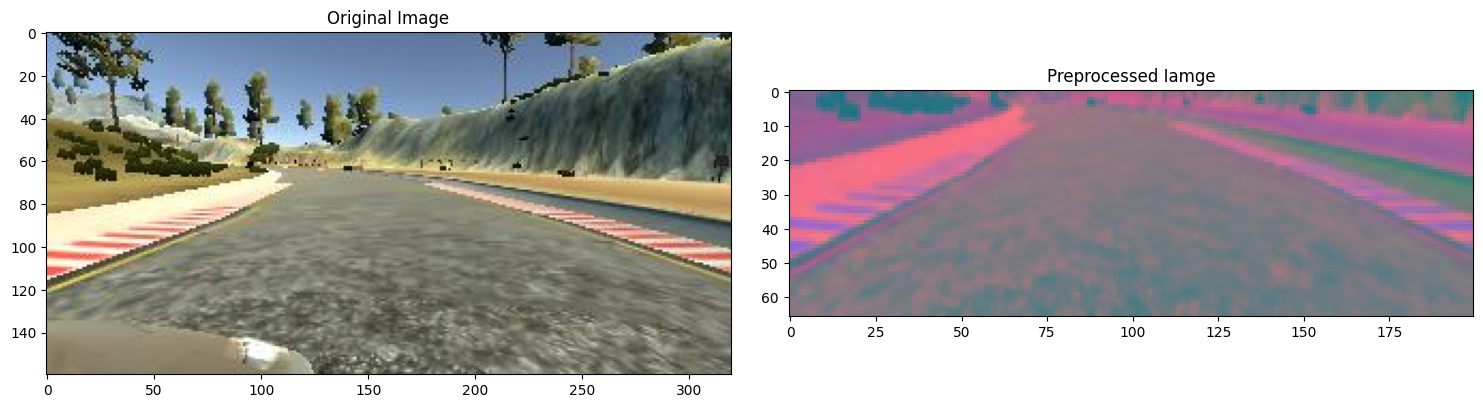

In [31]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1,2, figsize= (15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Iamge')

In [32]:
!nvidia-smi

Mon Jul 29 12:26:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [33]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths)-1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

            else:
                im = mpimg.imread(image_paths[random_index])
                steering =steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)


        yield (np.asarray(batch_img), np.asarray(batch_steering))

In [34]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

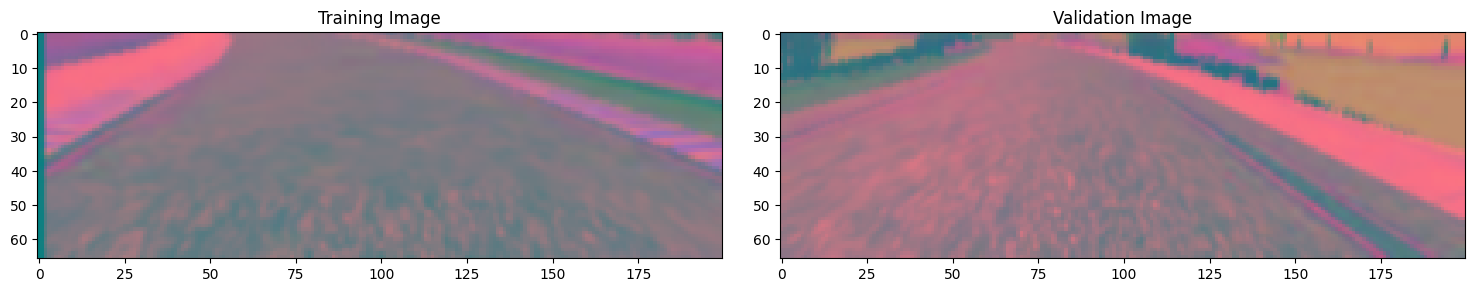

In [35]:
fig, axs = plt.subplots(1,2,figsize =( 15,10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [36]:
  def nvidia_model():
      model= Sequential()
      model.add(Conv2D(24,(5,5), strides= (2,2), input_shape= (66,200,3), activation= 'elu'))
      model.add(Conv2D(36,(5,5), strides= (2,2), activation= 'elu'))
      model.add(Conv2D(48,(5,5), strides= (2,2), activation= 'elu'))
      model.add(Conv2D(64,(5,5), activation= 'elu'))

      model.add(Flatten())
      model.add(Dense(100, activation= 'elu'))
      #model.add(Dropout(0.5))

      model.add(Dense(50, activation= 'elu'))
      #model.add(Dropout(0.5))

      model.add(Dense(10, activation= 'elu'))
      #model.add(Dropout(0.5))

      model.add(Dense(1))
      optimizer = tf.keras.optimizers.Adam(learning_rate=  1e-3)
      model.compile(loss='mse', optimizer= optimizer)
      return model
  model= nvidia_model()
  print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               115300    
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [37]:
history = model.fit(batch_generator(X_train, y_train, 100,1 ), steps_per_epoch= 300, epochs=15, validation_data= batch_generator(X_valid, y_valid, 100, 0), validation_steps= 200, verbose=1, shuffle= 1)

Epoch 1/15
300/300 [==============================] - 137s 432ms/step - loss: 0.1456 - val_loss: 0.0875
Epoch 2/15
300/300 [==============================] - 114s 381ms/step - loss: 0.0956 - val_loss: 0.0778
Epoch 3/15
300/300 [==============================] - 113s 377ms/step - loss: 0.0860 - val_loss: 0.0681
Epoch 4/15
300/300 [==============================] - 114s 381ms/step - loss: 0.0740 - val_loss: 0.0595
Epoch 5/15
300/300 [==============================] - 116s 388ms/step - loss: 0.0669 - val_loss: 0.0509
Epoch 6/15
300/300 [==============================] - 119s 398ms/step - loss: 0.0631 - val_loss: 0.0459
Epoch 7/15
300/300 [==============================] - 150s 503ms/step - loss: 0.0599 - val_loss: 0.0489
Epoch 8/15
300/300 [==============================] - 104s 346ms/step - loss: 0.0591 - val_loss: 0.0525
Epoch 9/15
300/300 [==============================] - 136s 454ms/step - loss: 0.0562 - val_loss: 0.0434
Epoch 10/15
300/300 [==============================] - 103s 343m

Text(0.5, 0, 'Epoch')

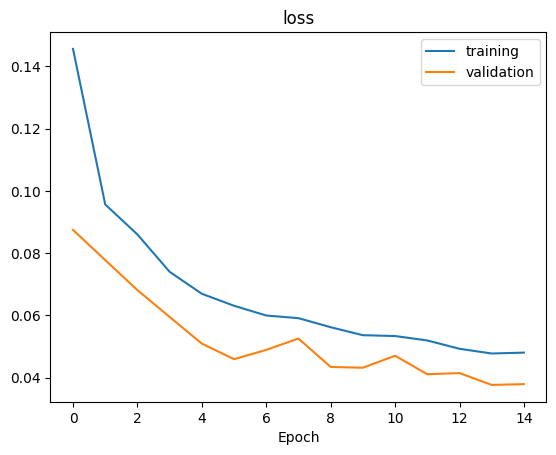

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('Epoch')

In [39]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>